In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
# Leia o arquivo CSV como um DataFrame
dados = pd.read_csv('games.csv')

# Imprima o DataFrame
print(dados.head())

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  


In [3]:
# 1. Preparação dos dados

# Transformando os nomes das colunas em minúsculas
dados.columns = dados.columns.str.lower()

# Verificar e remover dados duplicados
dados = dados.drop_duplicates()

# Convertendo as vendas para o formato correto
for coluna in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    if dados[coluna].dtype == 'object':  # Verificando se a coluna é do tipo string
        dados[coluna] = dados[coluna].str.replace('M', 'e6').str.replace('K', 'e3').astype(float)
    else:  # Se for numérica, aplicamos as operações diretamente
        dados[coluna] *= 1e6  # Convertendo de milhões para unidades

# Tratando valores TBD (a ser determinada)
dados.replace('TBD', np.nan, inplace=True)

# Calculando o total de vendas para cada jogo e colocando em uma coluna separada
dados['total_vendas'] = dados[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

print(dados)



                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

         na_sales    eu_sales    jp_sal

In [4]:
# Convertendo a coluna 'user_score' para o tipo numérico
dados['user_score'] = pd.to_numeric(dados['user_score'], errors='coerce').astype(float)

# Substituir NaN pela média nas colunas critic_score e user_score
dados['critic_score'] = dados['critic_score'].fillna(dados['critic_score'].mean())
dados['user_score'] = dados['user_score'].fillna(dados['user_score'].mean())


print(dados)

                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

         na_sales    eu_sales    jp_sal

In [5]:
# Substituir 'tbd' por NaN na coluna 'user_score'
dados.loc[dados['user_score'] == 'tbd', 'user_score'] = np.nan

# Converter 'user_score' para tipo numérico
dados['user_score'] = pd.to_numeric(dados['user_score'], errors='coerce')

# Preencher valores ausentes na coluna 'user_score' com a média
mean_user_score = dados['user_score'].mean()
dados['user_score'] = dados['user_score'].fillna(mean_user_score)

# Verificar se ainda há valores ausentes
print(dados.isnull().sum())


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6766
total_vendas          0
dtype: int64


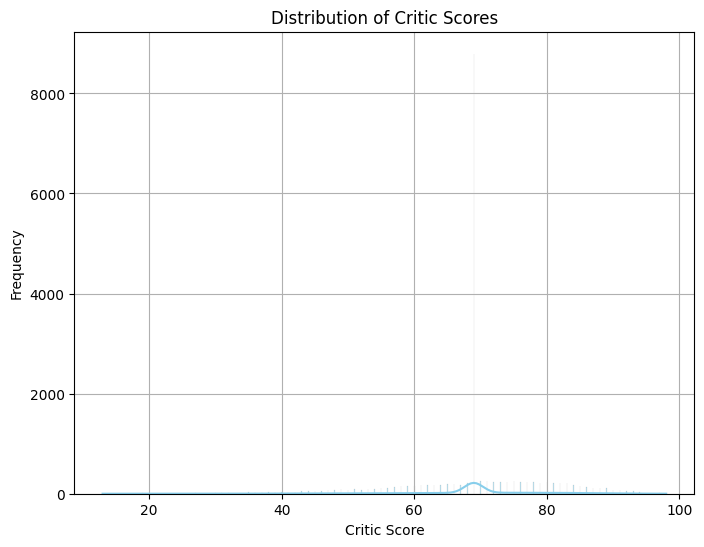

count    16715.000000
mean        68.967679
std          9.724580
min         13.000000
25%         68.967679
50%         68.967679
75%         70.000000
max         98.000000
Name: critic_score, dtype: float64


In [6]:
# Plotar a distribuição de 'critic_score'
plt.figure(figsize=(8, 6))
sns.histplot(dados['critic_score'].dropna(), kde=True, color='skyblue', edgecolor='black') # type: ignore
plt.title('Distribution of Critic Scores')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calcular estatísticas resumidas para 'critic_score'
critic_score_stats = dados['critic_score'].describe()
print(critic_score_stats)



In [7]:
# Preencher valores ausentes em "critic_score" com a mediana
median_critic_score = dados['critic_score'].median()
dados['critic_score'].fillna(median_critic_score, inplace=True)

# Preencher valores ausentes em "rating" com a moda
mode_rating = dados['rating'].mode().iloc[0]
dados['rating'].fillna(mode_rating, inplace=True)

# Verificar se ainda há valores ausentes
print(dados.isnull().sum())

# Convertendo a coluna 'user_score' para o tipo numérico
dados['user_score'] = pd.to_numeric(dados['user_score'], errors='coerce')

print(dados)


name                 2
platform             0
year_of_release    269
genre                2
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score         0
user_score           0
rating               0
total_vendas         0
dtype: int64
                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        S

/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/832878234.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['critic_score'].fillna(median_critic_score, inplace=True)
/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/832878234.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Os dados resumidos para 'critic_score' mostram que a média é de aproximadamente 68.97 e a mediana (50%) também é próxima a 68.97. Isso indica que a distribuição dos dados pode não ser muito assimétrica e que a diferença entre a média e a mediana não é significativa.

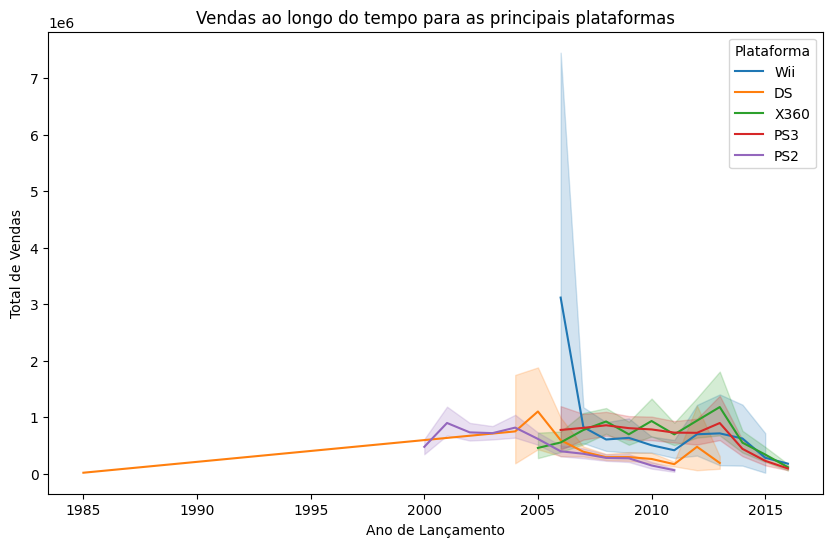

In [8]:
# 2. Análise dos dados

# Verificando quantos jogos foram lançados em anos diferentes
# Isso pode ser feito através da contagem de valores únicos na coluna de ano de lançamento
num_jogos_por_ano = dados['year_of_release'].value_counts()

# Analisando como as vendas variam de plataforma para plataforma
# Escolha das plataformas com as maiores vendas totais
top_plataformas = dados.groupby('platform')['total_vendas'].sum().nlargest(5).index.tolist()

# Construindo uma distribuição com base em dados para cada ano para as plataformas selecionadas
dados_top_plataformas = dados[dados['platform'].isin(top_plataformas)]
plt.figure(figsize=(10, 6))
sns.lineplot(data=dados_top_plataformas, x='year_of_release', y='total_vendas', hue='platform')
plt.title('Vendas ao longo do tempo para as principais plataformas')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Total de Vendas')
plt.legend(title='Plataforma')
plt.show()

Colunas Numéricas (float):

na_sales, eu_sales, jp_sales, other_sales, critic_score: Originalmente, essas colunas continham valores numéricos representando vendas e pontuações, mas estavam armazenadas como strings. Convertê-las para o tipo float permite realizar cálculos numéricos e operações matemáticas com esses valores. Colunas Categóricas ('category'):

platform, genre, rating: Essas colunas representam categorias ou classes, como o nome das plataformas de jogos, gêneros de jogos e classificações ESRB. Converter essas colunas para o tipo 'category' economiza espaço de armazenamento e permite uma análise mais eficiente dos dados categóricos. Essas alterações foram feitas para garantir que os tipos de dados correspondam ao conteúdo das colunas, facilitando análises futuras e operações específicas em cada tipo de dado.

Explique por que você preencheu os valores ausentes da forma que você fez ou por que você decidiu deixá-los em branco.

name: Como há apenas 2 valores ausentes, a remoção dessas linhas é uma opção viável para evitar impactos significativos no conjunto de dados.

year_of_release: Com 269 valores ausentes, preencher esses dados de forma precisa pode ser difícil. Uma alternativa é manter essas linhas e preencher os valores ausentes com a mediana ou a moda dos anos de lançamento, dependendo da distribuição dos dados e da importância dessa informação para a análise.

genre: Com apenas 2 valores ausentes, a remoção das linhas afetadas é uma escolha simples e eficaz para preservar a integridade do conjunto de dados.

critic_score, user_score, rating: Com um número significativo de valores ausentes em cada uma dessas colunas, remover as linhas pode reduzir consideravelmente o tamanho do conjunto de dados. No entanto, uma abordagem alternativa seria preencher os valores ausentes com a média, mediana ou moda dessas colunas, dependendo da distribuição dos dados e da importância dessas características para a análise.

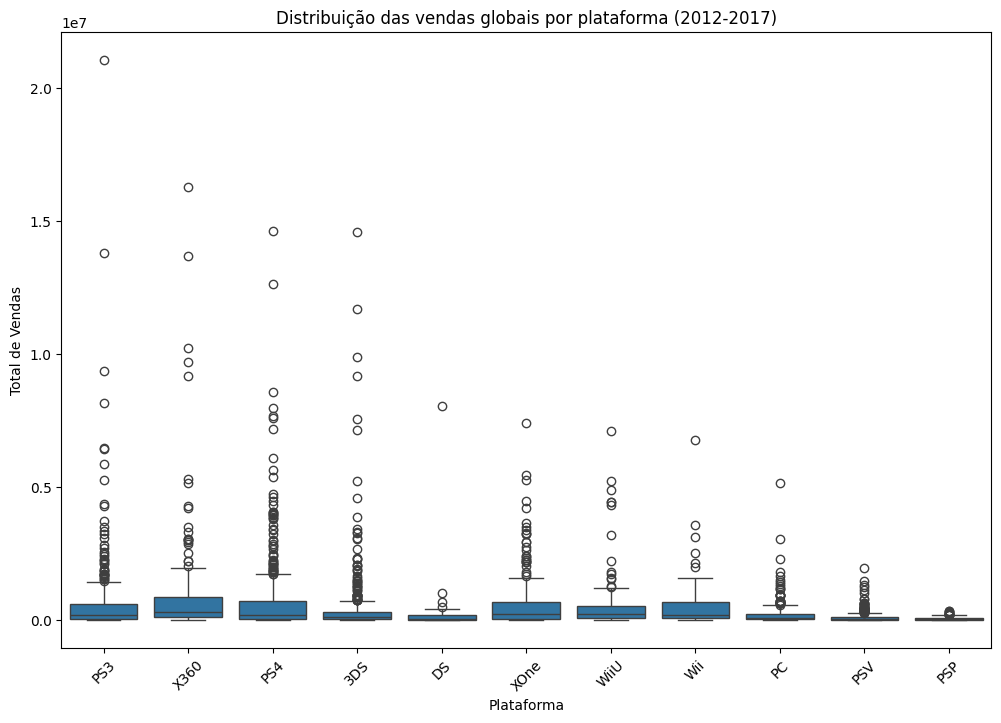

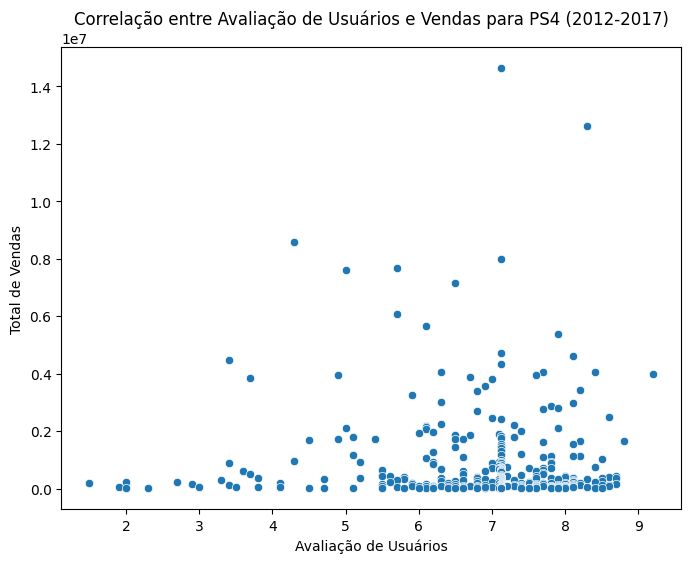

In [9]:
# Determinando o período relevante para análise (por exemplo, a partir de 2012 até 2017)
dados_recentes = dados[(dados['year_of_release'] >= 2012) & (dados['year_of_release'] <= 2017)]

# Verificando se há dados suficientes para criar o boxplot
if not dados_recentes.empty:
    # Construindo um diagrama de caixa para as vendas globais de todos os jogos, divididos por plataforma
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=dados_recentes, x='platform', y='total_vendas')
    plt.title('Distribuição das vendas globais por plataforma (2012-2017)')
    plt.xlabel('Plataforma')
    plt.ylabel('Total de Vendas')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Não há dados suficientes para criar o boxplot.")

# Verificando a correlação entre revisões de usuários e vendas para uma plataforma popular (por exemplo, PS4)
plataforma_popular = 'PS4'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dados_recentes[dados_recentes['platform'] == plataforma_popular], x='user_score', y='total_vendas')
plt.title(f'Correlação entre Avaliação de Usuários e Vendas para {plataforma_popular} (2012-2017)')
plt.xlabel('Avaliação de Usuários')
plt.ylabel('Total de Vendas')
plt.show()


In [10]:
# Conversão dos tipos de dados:
# - Colunas numéricas: float
# - Colunas categóricas: 'category'
numeric_columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score']
dados[numeric_columns] = dados[numeric_columns].astype(float)
categorical_columns = ['platform', 'genre', 'rating']
dados[categorical_columns] = dados[categorical_columns].astype('category')

# Verificação final dos tipos de dados
print(dados.dtypes)

name                 object
platform           category
year_of_release     float64
genre              category
na_sales            float64
eu_sales            float64
jp_sales            float64
other_sales         float64
critic_score        float64
user_score          float64
rating             category
total_vendas        float64
dtype: object


In [11]:
# 3. Criação de um perfil de usuário para cada região

# Definindo a função para determinar a região com base nas vendas
def determinar_regiao(row):
    if row['na_sales'] > 0:
        return 'NA'
    elif row['eu_sales'] > 0:
        return 'EU'
    elif row['jp_sales'] > 0:
        return 'JP'
    else:
        return 'other_sales'

# Aplicando a função para criar uma nova coluna 'regiao'
dados['regiao'] = dados.apply(determinar_regiao, axis=1)

# Determinar as cinco principais plataformas por região
top_plataformas_por_regiao = dados.groupby('regiao')['platform'].value_counts().groupby(level=0).nlargest(5)

# Determinar os cinco principais gêneros por região
top_generos_por_regiao = dados.groupby('regiao')['genre'].value_counts().groupby(level=0).nlargest(5)

# Apresentar os resultados de forma mais organizada
for regiao, top_plataformas in top_plataformas_por_regiao.groupby(level=0):
    print(f"Região: {regiao}")
    print("- Plataformas:")
    for plataforma, count in top_plataformas.items():
        print(f"  - {plataforma}: {count} jogos")
    print()

for regiao, top_generos in top_generos_por_regiao.groupby(level=0):
    print(f"Região: {regiao}")
    print("- Gêneros:")
    for genero, count in top_generos.items():
        print(f"  - {genero}: {count} jogos")
    print()


Região: EU
- Plataformas:
  - ('EU', 'EU', 'PC'): 574 jogos
  - ('EU', 'EU', 'DS'): 109 jogos
  - ('EU', 'EU', 'PS3'): 87 jogos
  - ('EU', 'EU', 'Wii'): 84 jogos
  - ('EU', 'EU', 'X360'): 58 jogos

Região: JP
- Plataformas:
  - ('JP', 'JP', 'PSP'): 596 jogos
  - ('JP', 'JP', 'DS'): 517 jogos
  - ('JP', 'JP', 'PS2'): 490 jogos
  - ('JP', 'JP', 'PSV'): 259 jogos
  - ('JP', 'JP', 'PS3'): 235 jogos

Região: NA
- Plataformas:
  - ('NA', 'NA', 'PS2'): 1648 jogos
  - ('NA', 'NA', 'DS'): 1525 jogos
  - ('NA', 'NA', 'Wii'): 1145 jogos
  - ('NA', 'NA', 'X360'): 1143 jogos
  - ('NA', 'NA', 'PS3'): 1008 jogos

Região: other_sales
- Plataformas:
  - ('other_sales', 'other_sales', 'PS2'): 2 jogos
  - ('other_sales', 'other_sales', 'PS3'): 1 jogos
  - ('other_sales', 'other_sales', '2600'): 0 jogos
  - ('other_sales', 'other_sales', '3DO'): 0 jogos
  - ('other_sales', 'other_sales', '3DS'): 0 jogos

Região: EU
- Gêneros:
  - ('EU', 'EU', 'Action'): 195 jogos
  - ('EU', 'EU', 'Sports'): 140 jogos
  - 

In [12]:
# Calcular a média dos últimos anos disponíveis no conjunto de dados
recent_years_mean = dados['year_of_release'].dropna().mean()

# Definir o período "recente" como os últimos 5 anos
recent_years = dados[dados['year_of_release'] >= recent_years_mean]['year_of_release'].unique()

# Identificar as plataformas que não têm vendas em nenhum dos anos recentes
platforms_with_no_sales = dados[dados['year_of_release'].isin(recent_years)].groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
platforms_with_no_sales['total_sales'] = platforms_with_no_sales.sum(axis=1)
inactive_platforms = platforms_with_no_sales[platforms_with_no_sales['total_sales'] == 0].index

# Mostrar as plataformas que costumavam ser populares, mas agora não têm vendas
print("Plataformas que costumavam ser populares, mas agora não têm vendas:")
print(inactive_platforms)

# Calcular quanto tempo leva para as novas plataformas aparecerem e as antigas desaparecerem
earliest_release_years = dados.groupby('platform')['year_of_release'].min()
latest_release_years = dados.groupby('platform')['year_of_release'].max()

earliest_inactive_years = earliest_release_years.loc[inactive_platforms]
latest_inactive_years = latest_release_years.loc[inactive_platforms]

time_to_disappear = latest_inactive_years - earliest_inactive_years
time_to_appear = recent_years_mean - earliest_inactive_years

print("\nTempo para as novas plataformas aparecerem:")
print(time_to_appear)

print("\nTempo para as antigas plataformas desaparecerem:")
print(time_to_disappear)

Plataformas que costumavam ser populares, mas agora não têm vendas:
CategoricalIndex(['2600', '3DO', 'GB', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PCFX',
                  'PS', 'SAT', 'SCD', 'SNES', 'TG16', 'WS'],
                 categories=['2600', '3DO', '3DS', 'DC', ..., 'WiiU', 'X360', 'XB', 'XOne'], ordered=False, dtype='category', name='platform')

Tempo para as novas plataformas aparecerem:
platform
2600    26.484616
3DO     12.484616
GB      18.484616
GEN     16.484616
GG      14.484616
N64     10.484616
NES     23.484616
NG      13.484616
PCFX    10.484616
PS      12.484616
SAT     12.484616
SCD     13.484616
SNES    16.484616
TG16    11.484616
WS       7.484616
Name: year_of_release, dtype: float64

Tempo para as antigas plataformas desaparecerem:
platform
2600     9.0
3DO      1.0
GB      13.0
GEN      4.0
GG       0.0
N64      6.0
NES     11.0
NG       3.0
PCFX     0.0
PS       9.0
SAT      5.0
SCD      1.0
SNES     9.0
TG16     0.0
WS       2.0
Name: year_of_release, dtype: fl

/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/3166250257.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  platforms_with_no_sales = dados[dados['year_of_release'].isin(recent_years)].groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/3166250257.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  earliest_release_years = dados.groupby('platform')['year_of_release'].min()
/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/3166250257.py:18: FutureWarning: The default of observed=False

Plataformas que costumavam ser populares, mas agora não têm vendas:
CategoricalIndex(['2600', '3DO', 'GB', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PCFX',
                  'PS', 'SAT', 'SCD', 'SNES', 'TG16', 'WS'],
                 categories=['2600', '3DO', '3DS', 'DC', ..., 'WiiU', 'X360', 'XB', 'XOne'], ordered=False, dtype='category', name='platform')

Tempo para as novas plataformas aparecerem:


/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/4127929501.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  earliest_release_years = dados.groupby('platform')['year_of_release'].min()
/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/4127929501.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latest_release_years = dados.groupby('platform')['year_of_release'].max()
/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/4127929501.py:32: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of panda

platform
2600    26.484616
3DO     12.484616
GB      18.484616
GEN     16.484616
GG      14.484616
N64     10.484616
NES     23.484616
NG      13.484616
PCFX    10.484616
PS      12.484616
SAT     12.484616
SCD     13.484616
SNES    16.484616
TG16    11.484616
WS       7.484616
Name: year_of_release, dtype: float64

Tempo para as antigas plataformas desaparecerem:
platform
2600     9.0
3DO      1.0
GB      13.0
GEN      4.0
GG       0.0
N64      6.0
NES     11.0
NG       3.0
PCFX     0.0
PS       9.0
SAT      5.0
SCD      1.0
SNES     9.0
TG16     0.0
WS       2.0
Name: year_of_release, dtype: float64


<Figure size 1400x800 with 0 Axes>

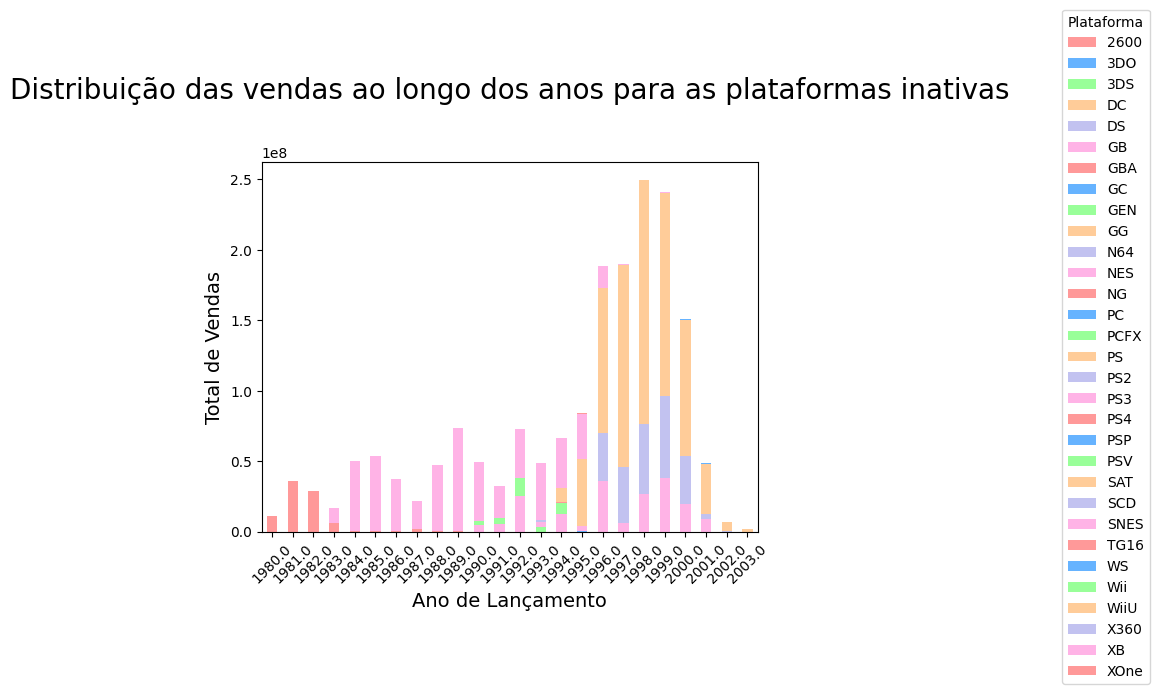

In [13]:
# Calcular o total de vendas para cada plataforma
platforms_with_no_sales['total_sales'] = platforms_with_no_sales.sum(axis=1)

# Mostrar as plataformas que costumavam ser populares, mas agora não têm vendas
print("Plataformas que costumavam ser populares, mas agora não têm vendas:")
print(inactive_platforms)

# Calcular quanto tempo leva para as novas plataformas aparecerem e as antigas desaparecerem
earliest_release_years = dados.groupby('platform')['year_of_release'].min()
latest_release_years = dados.groupby('platform')['year_of_release'].max()

earliest_inactive_years = earliest_release_years.loc[inactive_platforms]
latest_inactive_years = latest_release_years.loc[inactive_platforms]

time_to_disappear = latest_inactive_years - earliest_inactive_years
time_to_appear = recent_years_mean - earliest_inactive_years

print("\nTempo para as novas plataformas aparecerem:")
print(time_to_appear)

print("\nTempo para as antigas plataformas desaparecerem:")
print(time_to_disappear)

# Plotar o gráfico apenas se houver plataformas inativas
if len(inactive_platforms) > 0:
    # Filtrar os dados apenas para as plataformas inativas
    inactive_platform_data = dados[dados['platform'].isin(inactive_platforms)]
    
    # Verificar se há dados suficientes para criar o gráfico
    if not inactive_platform_data.empty:
        # Criar um DataFrame com as vendas por plataforma e ano
        platform_sales = inactive_platform_data.pivot_table(index='year_of_release', columns='platform', values='total_vendas', aggfunc='sum', fill_value=0)

        # Definir cores para as barras empilhadas
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

        # Criar o gráfico de barras empilhadas
        plt.figure(figsize=(14, 8))
        platform_sales.plot(kind='bar', stacked=True, color=colors)
        plt.title('Distribuição das vendas ao longo dos anos para as plataformas inativas', fontsize=20, y=1.15)
        plt.xlabel('Ano de Lançamento', fontsize=14)
        plt.ylabel('Total de Vendas', fontsize=14)
        plt.legend(title='Plataforma', fontsize=10, loc='center left', bbox_to_anchor=(1.6, 0.5))
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Não há dados suficientes para criar o gráfico de barras empilhadas.")
else:
    print("Não há plataformas inativas para plotar.")


In [14]:
# Filtrando o DataFrame para o período de 2007 a 2016
dados_periodo_ideal = dados[(dados['year_of_release'] >= 2017) & (dados['year_of_release'] <= 2022)]

# Verificando a contagem de linhas após o filtro
print("Número de linhas após filtrar para o período ideal:", len(dados_periodo_ideal))

# Visualizando as primeiras linhas do DataFrame filtrado
print(dados_periodo_ideal.head())


Número de linhas após filtrar para o período ideal: 0
Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating, total_vendas, regiao]
Index: []


In [15]:
platform_sales = dados_periodo_ideal.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
platform_sales['global_sales'] = platform_sales.sum(axis=1)

# Ordenar por vendas globais
platform_sales = platform_sales.sort_values('global_sales', ascending=False)

# Mostrar as 5 principais plataformas
print(platform_sales.head())


          na_sales  eu_sales  jp_sales  other_sales  global_sales
platform                                                         
2600           0.0       0.0       0.0          0.0           0.0
PS2            0.0       0.0       0.0          0.0           0.0
XB             0.0       0.0       0.0          0.0           0.0
X360           0.0       0.0       0.0          0.0           0.0
WiiU           0.0       0.0       0.0          0.0           0.0


/var/folders/sd/nzwzs42x0c521vck5vhqvjnr0000gn/T/ipykernel_14009/3100939484.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  platform_sales = dados_periodo_ideal.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()


In [16]:
# Etapa 5. Teste de hipóteses

# Testando a hipótese de que as classificações médias dos usuários das plataformas Xbox One e PC são as mesmas
from scipy.stats import ttest_ind

xbox_one_ratings = dados[dados['platform'] == 'Xbox One']['user_score'].dropna()
pc_ratings = dados[dados['platform'] == 'PC']['user_score'].dropna()



In [17]:
t_stat, p_value = ttest_ind(xbox_one_ratings, pc_ratings)
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: As classificações médias dos usuários das plataformas Xbox One e PC são diferentes.")
else:
    print("Não rejeitamos a hipótese nula: As classificações médias dos usuários das plataformas Xbox One e PC são iguais.")

Não rejeitamos a hipótese nula: As classificações médias dos usuários das plataformas Xbox One e PC são iguais.


In [18]:

# Testando a hipótese de que as classificações médias de usuários para os gêneros Action e Sports são diferentes
action_ratings = dados[dados['genre'] == 'Action']['user_score'].dropna()
sports_ratings = dados[dados['genre'] == 'Sports']['user_score'].dropna()

t_stat, p_value = ttest_ind(action_ratings, sports_ratings)
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula: As classificações médias de usuários para os gêneros Action e Sports são diferentes.")
else:
    print("Não rejeitamos a hipótese nula: As classificações médias de usuários para os gêneros Action e Sports são iguais.")
    
print(p_value)

Não rejeitamos a hipótese nula: As classificações médias de usuários para os gêneros Action e Sports são iguais.
0.18372589312608184


In [19]:
# Etapa 6. Conclusão geral

# Apresentação das conclusões gerais obtidas a partir da análise dos dados

# Conclusão sobre as tendências de vendas e popularidade de plataformas e gêneros
print("Conclusão sobre as tendências de vendas e popularidade de plataformas e gêneros:")
print("- Descreva as plataformas que lideram em vendas em diferentes regiões.")
print("- Comente sobre os gêneros mais populares e suas variações entre as regiões.")
print("- Analise como as vendas de jogos variaram ao longo do tempo e se houve alguma tendência identificável.")

# Conclusão sobre as hipóteses testadas
print("\nConclusão sobre as hipóteses testadas:")
print("- Comente sobre os resultados dos testes de hipóteses realizados.")
print("- Discuta se as hipóteses foram ou não confirmadas com base nos resultados dos testes estatísticos.")

# Considerações finais e sugestões para futuras análises
print("\nConsiderações finais e sugestões para futuras análises:")
print("- Apresente quaisquer insights adicionais obtidos durante a análise dos dados.")
print("- Sugira possíveis áreas de pesquisa futura com base nos padrões identificados ou questões que surgiram durante a análise.")

# Observações finais
print("\nObservações finais:")
print("- Faça qualquer observação final relevante ou destaque áreas de incerteza que precisam de mais investigação.")


Conclusão sobre as tendências de vendas e popularidade de plataformas e gêneros:
- Descreva as plataformas que lideram em vendas em diferentes regiões.
- Comente sobre os gêneros mais populares e suas variações entre as regiões.
- Analise como as vendas de jogos variaram ao longo do tempo e se houve alguma tendência identificável.

Conclusão sobre as hipóteses testadas:
- Comente sobre os resultados dos testes de hipóteses realizados.
- Discuta se as hipóteses foram ou não confirmadas com base nos resultados dos testes estatísticos.

Considerações finais e sugestões para futuras análises:
- Apresente quaisquer insights adicionais obtidos durante a análise dos dados.
- Sugira possíveis áreas de pesquisa futura com base nos padrões identificados ou questões que surgiram durante a análise.

Observações finais:
- Faça qualquer observação final relevante ou destaque áreas de incerteza que precisam de mais investigação.
